# Transformer model on KTH dataset

Change the project path to the appropriate project folder path

In [ ]:
 !pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow
    Foun

In [ ]:
path= 'drive/MyDrive/HumanActionRecognition/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/HumanActionRecognition/Utils/tools/an_example_skeleton_of_standing.py .

In [ ]:
!cp drive/MyDrive/HumanActionRecognition/Utils/utils/lib_plot.py .

In [ ]:
!cp drive/MyDrive/HumanActionRecognition/Utils/utils/lib_commons.py .

In [ ]:
!pip install simplejson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 12.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import random
from random import randint
import time
import os
from scipy.spatial.distance import pdist
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import imageio
import os

In [ ]:
import cv2
import simplejson
from sklearn.preprocessing import OneHotEncoder
from an_example_skeleton_of_standing import get_a_normalized_jhmdb_skeleton
from collections import deque
import pickle
import sklearn.model_selection
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import lib_plot as lib_plot
import lib_commons as lib_commons
import math
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization


In [ ]:
def draw(skeleton): # helper function to draw skeleton
    x = skeleton[0::2]
    y = skeleton[1::2]
    plt.plot(x, y, "r*")
    plt.axis("equal")
    plt.show()


#Data augmentation:

1. Flips original data along x-axis
2. Adds Gaussian noise to original data with sigma 0.02
3. Adds Gaussian noise to original data with sigma 0.04
4. Rotates flipped data to 15°
5. Rotates flipped data to -15°
6. Rotates flipped data to 30°
7. Rotates flipped data to -30°

In [ ]:
def data_augment(x_df, y_df, size):
    #flipping
    x_copy = x_df.copy()
    x_copy[x_copy.columns[::2]] = x_copy[x_copy.columns[::2]].apply(lambda x: -x)
    x_flipped = pd.concat([x_df, x_copy], ignore_index=True)
    y_copy = y_df.copy()
    y_flipped = pd.concat([y_df, y_copy], ignore_index=True)
    #noising
    mu, sigma1 = 0, 0.02
    noise = np.random.normal(mu, sigma1, [size,30])
    x_noise = x_df + noise
    x_noised = pd.concat([x_flipped, x_noise], ignore_index=True)
    y_noised = pd.concat([y_flipped, y_copy], ignore_index=True)
    #noising2
    sigma2 = 0.04
    noise2 = np.random.normal(mu, sigma2, [size,30])
    x_noise2 = x_df + noise2
    x_noised2 = pd.concat([x_noised, x_noise2], ignore_index=True)
    y_noised2 = pd.concat([y_noised, y_copy], ignore_index=True)
    # rotate1
    x_rotate1 = x_flipped.apply(lambda x: rotate(x.to_numpy(), 15), axis=1, result_type='broadcast')
    x_rotated = pd.concat([x_noised2, x_rotate1], ignore_index=True)
    y_rotated = pd.concat([y_noised2, y_flipped], ignore_index=True)
    #rotate2
    x_rotate2 = x_flipped.apply(lambda x: rotate(x.to_numpy(), -15), axis=1, result_type='broadcast')
    x_rotated2 = pd.concat([x_rotated, x_rotate2], ignore_index=True)
    y_rotated2 = pd.concat([y_rotated, y_flipped], ignore_index=True)
    #rotate3
    x_rotate3 = x_flipped.apply(lambda x: rotate(x.to_numpy(), 30), axis=1, result_type='broadcast')
    x_rotated3 = pd.concat([x_rotated2, x_rotate3], ignore_index=True)
    y_rotated3 = pd.concat([y_rotated2, y_flipped], ignore_index=True)
    # rotate4
    x_rotate4 = x_flipped.apply(lambda x: rotate(x.to_numpy(), -30), axis=1, result_type='broadcast')
    x_rotated4 = pd.concat([x_rotated3, x_rotate4], ignore_index=True)
    y_rotated4 = pd.concat([y_rotated3, y_flipped], ignore_index=True)

    return x_rotated4, y_rotated4

In [ ]:
def rotate_joint(joint: tuple, p: int) -> tuple:
    x, y = joint
    psi = np.deg2rad(p)

    a = np.array([[np.cos(psi), -np.sin(psi)],
                  [np.sin(psi), np.cos(psi)]])
    b = np.array([x, y])
    joint = np.matmul(a, b)
    return joint

def rotate(frame, p: int) -> np.array:
    frame = frame.reshape(-1, 2)
    rotated = np.array([rotate_joint(joint=joint, p=p) for joint in frame])
    return rotated.reshape(-1)

# Feature extraction

In [ ]:
WINDOW_SIZE = int(5) # number of frames in action-snippet used to extract features.

In [ ]:
import numpy as np
CLASSES = np.array(['0', '1', '2', '3', '4', '5'])

In [ ]:
# with open("/content/drive/MyDrive/HRNET/Train_cut", "rb") as fp:   # Unpickling
#   train = pickle.load(fp)

# with open("/content/drive/MyDrive/HRNET/Val_cut", "rb") as fp:   # Unpickling
#   val = pickle.load(fp)

# with open("/content/drive/MyDrive/HRNET/Test_cut", "rb") as fp:   # Unpickling
#   test = pickle.load(fp)

train = np.load('/content/drive/MyDrive/Abu_KTH/Mediapipe/train_poses.npy', allow_pickle=True)
val = np.load('/content/drive/MyDrive/Abu_KTH/Mediapipe/val_poses.npy', allow_pickle=True)
test = np.load('/content/drive/MyDrive/Abu_KTH/Mediapipe/test_poses.npy', allow_pickle=True)
train = train.tolist()
val = val.tolist()
test = test.tolist()

In [ ]:
train = train + val
train_labels = train_labels + val_labels

In [ ]:
def zoom(p, target_l=32, joints_num=33, joints_dim=2):
    l = p.shape[0]
    p_new = np.empty([target_l, joints_num, joints_dim])
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:, m, n] = medfilt(p[:, m, n], 3)
            p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]
    return p_new


In [ ]:
arr = np.random.rand(300, 33, 2)

# Access every tenth row
arr_every_tenth_row = arr[::10]

# Print the shape of the resulting array
print(arr_every_tenth_row.shape)

(30, 33, 2)


In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from scipy.signal import medfilt
import scipy.ndimage.interpolation as inter
# Example data

# Example data
data = []
for video in train:
  video  = video[::10]
  video = zoom(video)
  data.append(video)

number_Of_videos = len(data)

# Reshape and concatenate the data for each frame of each video
frames = []
for i in range(number_Of_videos):
    for j in range(0, data[i].shape[0]):
        print(data[i].shape)
        reshaped_data = data[i][j].reshape((1, 33*2))
        frames.append(pd.DataFrame(data=reshaped_data))
print(len(frames))
# Concatenate the data frames into a single DataFrame
df_train = pd.concat(frames, ignore_index=True)

# Create column names for the DataFrame
columns = [f'pos{i}_coord{j}' for i in range(33) for j in range(2)]
df_train.columns = columns

# Print the first 5 rows of the DataFrame
print(df_train.head())

<ipython-input-94-1e4d36dec1fc>:7: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]


Выходные данные были обрезаны до нескольких последних строк (5000).
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33, 2)
(32, 33,

In [ ]:
print(df_train.tail())

       pos0_coord0  pos0_coord1  pos1_coord0  pos1_coord1  pos2_coord0  \
12251     0.503593     0.169135     0.508932     0.151420     0.510543   
12252     0.307091     0.161825     0.311640     0.145861     0.313125   
12253     0.135274     0.152632     0.139560     0.134648     0.141142   
12254    -0.017047     0.153857    -0.005760     0.134571    -0.002282   
12255    -0.039782     0.105309    -0.024868     0.095427    -0.020878   

       pos2_coord1  pos3_coord0  pos3_coord1  pos4_coord0  pos4_coord1  ...  \
12251     0.150991     0.512283     0.150644     0.508558     0.151559  ...   
12252     0.145412     0.314747     0.145094     0.311178     0.146355  ...   
12253     0.134480     0.142857     0.134525     0.139910     0.134173  ...   
12254     0.133610     0.001242     0.132702    -0.012986     0.134570  ...   
12255     0.095557    -0.016876     0.095750    -0.034295     0.095863  ...   

       pos28_coord0  pos28_coord1  pos29_coord0  pos29_coord1  pos30_coord0  \
1

In [ ]:
train_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/train.p", "rb"))
valid_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/test.p", "rb"))

In [ ]:
train_labels = []
for video in train_videos:
  train_labels.append(video['category'])
print(len(train_labels))
# train = train_poses


val_labels = []
for video in valid_videos:
  val_labels.append(video['category'])
print(len(val_labels))
# val = val_poses

test_labels = []
for video in test_videos:
  test_labels.append(video['category'])
print(len(test_labels))

191
192
216


In [ ]:
new_train_labels = []
for a in train_labels:
  if a == 'boxing':
    new_train_labels.append(0)
  elif a == 'handclapping':
    new_train_labels.append(1)
  elif a == 'handwaving':
    new_train_labels.append(2)
  elif a == 'jogging':
    new_train_labels.append(3)
  elif a == 'running':
    new_train_labels.append(4)
  else:
    new_train_labels.append(5)

print(new_train_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [ ]:
new_test_labels = []
for a in test_labels:
  if a == 'boxing':
    new_test_labels.append(0)
  elif a == 'handclapping':
    new_test_labels.append(1)
  elif a == 'handwaving':
    new_test_labels.append(2)
  elif a == 'jogging':
    new_test_labels.append(3)
  elif a == 'running':
    new_test_labels.append(4)
  else:
    new_test_labels.append(5)

print(new_test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [ ]:
train_labels = new_train_labels
test_labels = new_test_labels

In [ ]:
df_train_y = pd.DataFrame(train_labels)
df_train_y.head()

,0
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Example data

data = []
for video in test:
  video  = video[::10]
  video = zoom(video)
  data.append(video)
number_Of_videos = len(data)

# Reshape and concatenate the data for each frame of each video
frames = []
for i in range(number_Of_videos):
    for j in range(0, data[i].shape[0]):
        reshaped_data = data[i][j].reshape((1, 33*2))
        frames.append(pd.DataFrame(data=reshaped_data))

# Concatenate the data frames into a single DataFrame
df_test = pd.concat(frames, ignore_index=True)

# Create column names for the DataFrame
columns = [f'pos{i}_coord{j}' for i in range(33) for j in range(2)]
df_test.columns = columns

# Print the first 5 rows of the DataFrame
print(df_test.head())


df_test_y = pd.DataFrame(test_labels)


<ipython-input-94-1e4d36dec1fc>:7: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]


   pos0_coord0  pos0_coord1  pos1_coord0  pos1_coord1  pos2_coord0  \
0     0.463389     0.155386     0.469397     0.138264     0.470773   
1     0.480198     0.154725     0.483175     0.137574     0.484967   
2     0.481175     0.162920     0.487593     0.146236     0.488994   
3     0.484946     0.180979     0.488111     0.166438     0.489493   
4     0.495260     0.162451     0.502201     0.146910     0.504344   

   pos2_coord1  pos3_coord0  pos3_coord1  pos4_coord0  pos4_coord1  ...  \
0     0.137981     0.472343     0.137717     0.470786     0.137522  ...   
1     0.137332     0.486926     0.137107     0.483783     0.136793  ...   
2     0.145567     0.490587     0.144919     0.488047     0.145846  ...   
3     0.165833     0.491111     0.165152     0.488608     0.165715  ...   
4     0.146281     0.506541     0.145632     0.501706     0.146364  ...   

   pos28_coord0  pos28_coord1  pos29_coord0  pos29_coord1  pos30_coord0  \
0      0.526239      0.767981      0.559087      0.87

In [ ]:
print(len(train_labels))

383


In [ ]:
LABELS = ['boxing' 'handclapping', 'handwaving', 'jogging', 'running', 'walking']

In [ ]:
class Math():
    ''' Some math operations '''
    @staticmethod
    def calc_dist(p1, p0):
        return math.sqrt((p1[0]-p0[0])**2+(p1[1]-p0[1])**2)

    @staticmethod
    def pi2pi(x):
        if x > PI:
            x -= 2*PI
        if x <= -PI:
            x += 2*PI
        return x

    @staticmethod
    def calc_relative_angle(x1, y1, x0, y0, base_angle):
        # compute rotation from {base_angle} to {(x0,y0)->(x1,y1)}
        if (y1 == y0) and (x1 == x0):
            return 0
        a1 = np.arctan2(y1-y0, x1-x0)
        return Math.pi2pi(a1 - base_angle)

    @staticmethod
    def calc_relative_angle_v2(p1, p0, base_angle):
        # compute rotation from {base_angle} to {p0->p1}
        return Math.calc_relative_angle(p1[0], p1[1], p0[0], p0[1], base_angle)

In [ ]:
# -- Functions for processing features
def get_joint(x, idx):
    px = x[2*idx]
    py = x[2*idx+1]
    return px, py

def set_joint(x, idx, px, py):
    x[2*idx] = px
    x[2*idx+1] = py
    return

def check_joint(x, idx):
    return x[2*idx] != NaN

class ProcFtr(object):

    @staticmethod
    def drop_arms_and_legs_randomly(x, thresh=0.3):
        ''' Randomly drop one arm or one leg with a probability of thresh '''
        x = x.copy()
        N = len(ARMS_LEGS)
        rand_num = np.random.random()
        if rand_num < thresh:
            joint_idx = int((rand_num / thresh)*N)
            set_joint(x, joint_idx, NaN, NaN)
        return x

    @staticmethod
    def has_neck_and_thigh(x):
        ''' Check if a skeleton has a neck and at least one thigh '''
        return check_joint(x, NECK) and (check_joint(x, L_THIGH) or check_joint(x, R_THIGH))

    @staticmethod
    def get_body_height(x):
        ''' Compute height of the body, which is defined as:
            the distance between `neck` and `thigh`.
        '''
        x0, y0 = get_joint(x, NECK)

        # Get average thigh height
        x11, y11 = get_joint(x, L_THIGH)
        x12, y12 = get_joint(x, R_THIGH)
        if y11 == NaN and y12 == NaN:  # Invalid data
            return 1.0
        if y11 == NaN:
            x1, y1 = x12, y12
        elif y12 == NaN:
            x1, y1 = x11, y11
        else:
            x1, y1 = (x11 + x12) / 2, (y11 + y12) / 2

        # Get body height
        height = ((x0-x1)**2 + (y0-y1)**2)**(0.5)
        return height

    @staticmethod
    def remove_body_offset(x):
        ''' The origin is the neck.
        TODO: Deal with empty data.
        '''
        x = x.copy()
        px0, py0 = get_joint(x, NECK)
        x[0::2] = x[0::2] - px0
        x[1::2] = x[1::2] - py0
        return x

    @staticmethod
    def joint_pos_2_angle_and_length(x):
        ''' Change the representation of skeletons
            From xy positions to angle and length.
        '''
        # ---------------------- Get joint positions ----------------------
        class JointPosExtractor(object):
            def __init__(self, x):
                self.x = x
                self.i = 0

            def get_next_point(self):
                p = [self.x[self.i], self.x[self.i+1]]
                self.i += 2
                return p
        tmp = JointPosExtractor(x)

        pneck = tmp.get_next_point()

        prshoulder = tmp.get_next_point()
        prelbow = tmp.get_next_point()
        prwrist = tmp.get_next_point()

        plshoulder = tmp.get_next_point()
        plelbow = tmp.get_next_point()
        plwrist = tmp.get_next_point()

        prhip = tmp.get_next_point()
        prknee = tmp.get_next_point()
        prankle = tmp.get_next_point()

        plhip = tmp.get_next_point()
        plknee = tmp.get_next_point()
        plankle = tmp.get_next_point()

        # ---------------------- Get joint angels ----------------------
        class Get12Angles(object):
            def __init__(self):
                self.j = 0
                self.f_angles = np.zeros((12,))
                self.x_lengths = np.zeros((12,))

            def set_next_angle_len(self, next_joint, base_joint, base_angle):
                angle = Math.calc_relative_angle_v2(
                    next_joint, base_joint, base_angle)
                dist = Math.calc_dist(next_joint, base_joint)
                self.f_angles[self.j] = angle
                self.x_lengths[self.j] = dist
                self.j += 1

        tmp2 = Get12Angles()
        tmp2.set_next_angle_len(prshoulder, pneck, PI)  # r-shoulder
        tmp2.set_next_angle_len(prelbow, prshoulder, PI/2)  # r-elbow
        tmp2.set_next_angle_len(prwrist, prelbow, PI/2)  # r-wrist

        tmp2.set_next_angle_len(plshoulder, pneck, 0)  # l-shoulder
        tmp2.set_next_angle_len(plelbow, plshoulder, PI/2)  # l-elbow
        tmp2.set_next_angle_len(plwrist, plelbow, PI/2)  # l-wrist

        tmp2.set_next_angle_len(prhip, pneck, PI/2+PI/18)
        tmp2.set_next_angle_len(prknee, prhip, PI/2)
        tmp2.set_next_angle_len(prankle, prknee, PI/2)

        tmp2.set_next_angle_len(plhip, pneck, PI/2-PI/18)
        tmp2.set_next_angle_len(plknee, plhip, PI/2)
        tmp2.set_next_angle_len(plankle, plknee, PI/2)

        # Output
        features_angles = tmp2.f_angles
        features_lens = tmp2.x_lengths
        return features_angles, features_lens

Feature generator class:
1. Fills missing data with its relative position in previous frame
2. Generates normalized skeleton joints feature
3. Computes velocity of center feature
4. Computes velocity of joints feature
5. Computes euclidean distance of pairs of joints

In [ ]:
# -- The main class for extracting features
class FeatureGenerator(object):
    def __init__(self,
                 window_size,
                 is_adding_noise=False):
        '''
        Arguments:
            window_size {int}: Number of adjacent frames for extracting features.
            is_adding_noise {bool}: Is adding noise to the joint positions and scale.
            noise_intensity {float}: The noise relative to the body height.
        '''
        self._window_size = window_size
        self._is_adding_noise = is_adding_noise
        self._noise_intensity = NOISE_INTENSITY
        self.reset()

    def reset(self):
        ''' Reset the FeatureGenerator '''
        self._x_deque = deque()
        self._angles_deque = deque()
        self._lens_deque = deque()
        self._pre_x = None

    def add_cur_skeleton(self, skeleton):
        ''' Input a new skeleton, return the extracted feature.
        Returns:
            is_success {bool}: Return the feature only when
                the historical input skeletons are more than self._window_size.
            features {np.array}
        '''
        x = retrain_only_body_joints(skeleton)

#         if not ProcFtr.has_neck_and_thigh(x):
#             self.reset()
#             print('False', x)
#             return False, None
#         else:
        ''' The input skeleton has a neck and at least one thigh '''
            # -- Preprocess x
            # Fill zeros, compute angles/lens
        x = self._fill_invalid_data(x)
        if self._is_adding_noise:
                # Add noise druing training stage to augment data
            x = self._add_noises(x, self._noise_intensity)
        x = np.array(x)
        # angles, lens = ProcFtr.joint_pos_2_angle_and_length(x) # deprecate

            # Push to deque
        self._x_deque.append(x)
        # self._angles_deque.append(angles) # deprecate
        # self._lens_deque.append(lens) # deprecate

        self._maintain_deque_size()
        self._pre_x = x.copy()

            # -- Extract features
        if len(self._x_deque) < self._window_size:
            return False, None, None

        else:
                # -- Normalize all 1~t features
            h_list = [ProcFtr.get_body_height(xi) for xi in self._x_deque]
            mean_height = np.mean(h_list)
            xnorm_list = [ProcFtr.remove_body_offset(xi)/mean_height
                            for xi in self._x_deque]

                # -- Get features of pose/angles/lens
            f_poses = self._deque_features_to_1darray(xnorm_list)
            # f_angles = self._deque_features_to_1darray(self._angles_deque) # deprecate
            # f_lens = self._deque_features_to_1darray(
            #         self._lens_deque) / mean_height # deprecate

                #  Get features of motion

            f_v_center = self._compute_v_center(
                self._x_deque, step=1) / mean_height  # len = (t=4)*2 = 8
            f_v_center = np.repeat(f_v_center, 10)  # repeat to add weight

            f_v_joints = self._compute_v_all_joints(
                xnorm_list, step=1)  # len = (t=(5-1)/step)*12*2 = 96
            f_d_joints = self._compute_distance(xnorm_list)

                # -- Output
            features = np.concatenate((f_poses, f_v_joints, f_v_center))

            distance = f_d_joints
            return True, features.copy(), distance.copy()

    def _maintain_deque_size(self):
        if len(self._x_deque) > self._window_size:
            self._x_deque.popleft()
        if len(self._angles_deque) > self._window_size:
            self._angles_deque.popleft()
        if len(self._lens_deque) > self._window_size:
            self._lens_deque.popleft()

    def _compute_v_center(self, x_deque, step):
        vel = []
        for i in range(0, len(x_deque) - step, step):
            dxdy = x_deque[i+step][0:2] - x_deque[i][0:2]
            vel += dxdy.tolist()
        return np.array(vel)

    def _compute_v_all_joints(self, xnorm_list, step):
        vel = []
        for i in range(0, len(xnorm_list) - step, step):
            dxdy = xnorm_list[i+step][:] - xnorm_list[i][:]
            vel += dxdy.tolist()
        return np.array(vel)

    def _compute_distance(self, xnorm_list):
        dist = []
        for i in range(0, len(xnorm_list)):
            x = np.reshape(xnorm_list[i], (33, 2))
            dist_arr = pdist(x)
            dist+= dist_arr.tolist()
        #print('dist', len(dist))
        return np.array(dist)

    def _fill_invalid_data(self, x):
        ''' Fill the NaN elements in x with
            their relative-to-neck position in the preious x.
        Argument:
            x {np.array}: a skeleton that has a neck and at least a thigh.
        '''
        res = x.copy()

        def get_px_py_px0_py0(x):
            px = x[0::2]  # list of x
            py = x[1::2]  # list of y
            px0, py0 = get_joint(x, NECK)  # neck
            return px, py, px0, py0
        cur_px, cur_py, cur_px0, cur_py0 = get_px_py_px0_py0(x)
        cur_height = ProcFtr.get_body_height(x)

        is_lack_knee = check_joint(x, L_KNEE) or check_joint(x, R_KNEE)
        is_lack_ankle = check_joint(x, L_ANKLE) or check_joint(x, R_ANKLE)
        if (self._pre_x is None) or is_lack_knee or is_lack_ankle:
            # If preious data is invalid or there is no knee or ankle,
            # then fill the data based on the STAND_SKEL_NORMED.
            for i in range(TOTAL_JOINTS*2):
                if res[i] == NaN:
                    res[i] = (cur_px0 if i % 2 == 0 else cur_py0) + \
                        cur_height * STAND_SKEL_NORMED[i]
            return res

        pre_px, pre_py, pre_px0, pre_py0 = get_px_py_px0_py0(self._pre_x)
        pre_height = ProcFtr.get_body_height(self._pre_x)

        scale = cur_height / pre_height

        bad_idxs = np.nonzero(cur_px == NaN)[0]
        if not len(bad_idxs):  # No invalid data
            return res

        cur_px[bad_idxs] = cur_px0 + (pre_px[bad_idxs] - pre_px0) * scale
        cur_py[bad_idxs] = cur_py0 + (pre_py[bad_idxs] - pre_py0) * scale
        res[::2] = cur_px
        res[1::2] = cur_py
        return res


    def _add_noises(self, x, intensity):
        ''' Add noise to x with a ratio relative to the body height '''
        height = ProcFtr.get_body_height(x)
        randoms = (np.random.random(x.shape, ) - 0.5) * 2 * intensity * height
        x = [(xi + randoms[i] if xi != 0 else xi)
             for i, xi in enumerate(x)]
        return x

    def _deque_features_to_1darray(self, deque_data):
        features = []
        for i in range(len(deque_data)):
            next_feature = deque_data[i].tolist()
            features += next_feature
        features = np.array(features)
        return features

    def _deque_features_to_2darray(self, deque_data):
        features = []
        for i in range(len(deque_data)):
            next_feature = deque_data[i].tolist()
            features.append(next_feature)
        features = np.array(features)
        return features

Positions of skeleton joints

In [ ]:
# -- Settings
NOISE_INTENSITY = 0.05
# -- Constant
PI = np.pi
Inf = float("inf")
NaN = 0.0

def retrain_only_body_joints(skeleton):
    ''' All skeleton operations in this script are done after this function.
    '''
    return skeleton.copy()

TOTAL_JOINTS = 15
NECK = 0
Belly = 1
HEAD = 2
L_ARMS = [3, 7, 11]
R_ARMS = [4, 8, 12]
L_KNEE = 9
L_ANKLE = 13
R_KNEE = 10
R_ANKLE = 14
L_LEGS = [9, 13]
R_LEGS = [10, 14]
ARMS_LEGS = L_ARMS + R_ARMS + L_LEGS + R_LEGS
L_THIGH = 5
R_THIGH = 6

STAND_SKEL_NORMED = retrain_only_body_joints(
    get_a_normalized_jhmdb_skeleton())

In [ ]:
def process_features(X0, Y0, video_indices, classes):
    ''' Process features '''
    # Convert features
    # From: raw feature of individual image.
    # To:   time-serials features calculated from multiple raw features
    #       of multiple adjacent images, including velocity, normalized pos, etc.
    ADD_NOISE = False
    if ADD_NOISE:
        X1, Y1, X_distance1= extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE,
            is_adding_noise=True, is_print=True)
        X2, Y2, X_distance2 = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE,
            is_adding_noise=False, is_print=True)
        X = np.vstack((X1, X2))
        Y = np.concatenate((Y1, Y2))
        X_distance = np.vstack((X_distance1, X_distance2))
        return X, Y, X_distance
    else:
        X, Y, X_distance = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE,
            is_adding_noise=False, is_print=True)
        return X, Y, X_distance
# -- Functions
def extract_multi_frame_features(
        X, Y, video_indices, window_size,
        is_adding_noise=False, is_print=False):
    ''' From image index and raw skeleton positions,
        Extract features of body velocity, joint velocity, and normalized joint positions, distance feature.
    '''
    X_new = []
    Y_new = []
    N = len(video_indices)
    X_distance = []

    # Loop through all data

    for i, _ in enumerate(video_indices):

        # If a new video clip starts, reset the feature generator
        if i == 0 or video_indices[i] != video_indices[i-1]:
            fg = FeatureGenerator(window_size, is_adding_noise)

        # Get features
        success, features, distance = fg.add_cur_skeleton(X[i, :])
        if success:  # True if (data length > 5) and (skeleton has enough joints)
            X_new.append(features)
            Y_new.append(Y[i])
            X_distance.append(distance)

        # Print
        if is_print and i % 1000 == 0:
            print(f"{i}/{N}", end=", ")

    if is_print:
        print("")
    X_new = np.array(X_new)
    Y_new = np.array(Y_new)
    X_distance = np.array(X_distance)
    return X_new, Y_new, X_distance



# Data loading

JHMDB data has three splits and each of them splited into train and test set. Each set contains skeleton dataset and labels dataset.

Skeleton data in csv format and each row contains skeleton joint coordinates of one frame.

Dataset of labels contains action labels of each video.

# Split 1

In [ ]:
train = train+val

In [ ]:
x_1 = pd.read_csv(path+'jhmdb/data/GT_train_1.csv', header=None)
y_1 = pd.read_csv(path+'jhmdb/data/GT_train_y_1.csv', header=None)

In [ ]:
df_train.tail()

,pos0_coord0,pos0_coord1,pos1_coord0,pos1_coord1,pos2_coord0,pos2_coord1,pos3_coord0,pos3_coord1,pos4_coord0,pos4_coord1,...,pos28_coord0,pos28_coord1,pos29_coord0,pos29_coord1,pos30_coord0,pos30_coord1,pos31_coord0,pos31_coord1,pos32_coord0,pos32_coord1
12251,0.503593,0.169135,0.508932,0.151420,0.510543,0.150991,0.512283,0.150644,0.508558,0.151559,...,4.739248e-01,0.798173,5.919481e-01,0.846770,4.791176e-01,0.823765,5.301022e-01,0.854424,4.171441e-01,0.827505
12252,0.307091,0.161825,0.311640,0.145861,0.313125,0.145412,0.314747,0.145094,0.311178,0.146355,...,4.508335e-01,0.763677,3.084679e-01,0.827925,4.742016e-01,0.794110,2.383682e-01,0.836208,4.381360e-01,0.818604
12253,0.135274,0.152632,0.139560,0.134648,0.141142,0.134480,0.142857,0.134525,0.139910,0.134173,...,1.075507e-01,0.762820,2.561838e-01,0.816282,1.105954e-01,0.786577,1.934075e-01,0.829842,5.264505e-02,0.798001
12254,-0.017047,0.153857,-0.005760,0.134571,-0.002282,0.133610,0.001242,0.132702,-0.012986,0.134570,...,7.595568e-02,0.731407,1.066303e-01,0.755185,1.003642e-01,0.743144,5.168585e-02,0.795539,5.702913e-02,0.787313
12255,-0.039782,0.105309,-0.024868,0.095427,-0.020878,0.095557,-0.016876,0.095750,-0.034295,0.095863,...,1.447429e-17,0.669719,1.643988e-17,0.713988,1.428243e-17,0.688582,1.087827e-18,0.776477,8.928844e-18,0.737340


In [ ]:
train_labels = train_labels + val_labels

In [ ]:
df_train_y = pd.DataFrame(train_labels)
df_train_y.head()

,0
0,0
1,0
2,0
3,0
4,0


In [ ]:
df_train_y.tail()

,0
378,5
379,5
380,5
381,5
382,5


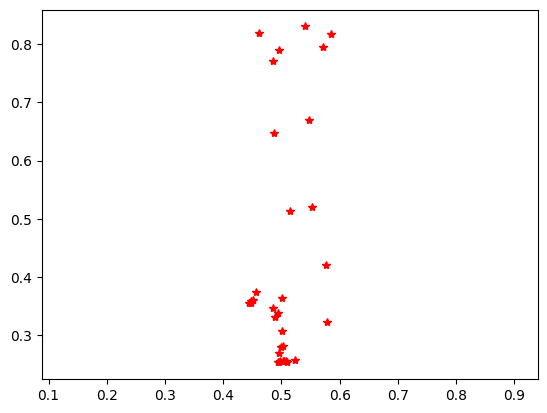

In [ ]:
draw(df_train.iloc[70])
df_train[df_train.columns[1::2]] = df_train[df_train.columns[1::2]].apply(lambda y: -y)


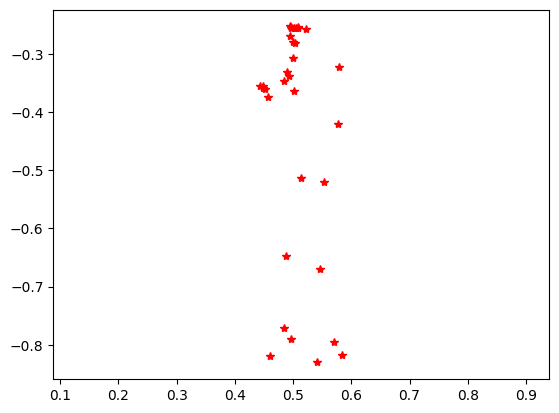

In [ ]:
draw(df_train.iloc[70])


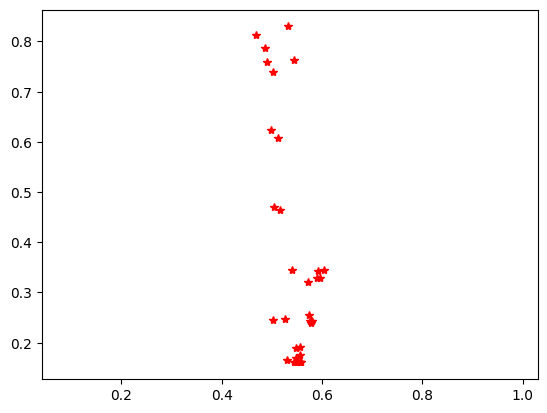

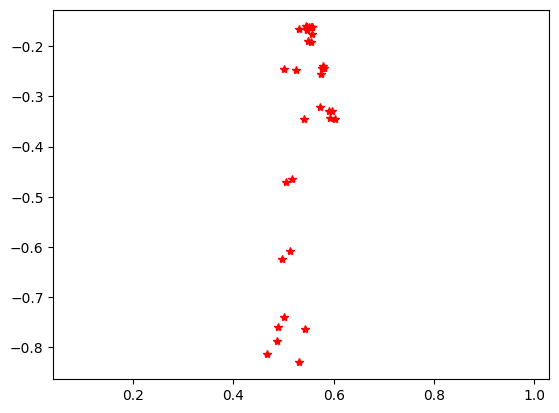

In [ ]:
draw(df_test.iloc[90])

df_test[df_test.columns[1::2]] = df_test[df_test.columns[1::2]].apply(lambda y: -y)
draw(df_test.iloc[90])

In [ ]:
print(x_1.iloc[15315])

NameError: ignored

In [ ]:
for a in train:
  print(a.shape)

(350, 33, 2)
(378, 33, 2)
(443, 33, 2)
(249, 33, 2)
(589, 33, 2)
(659, 33, 2)
(691, 33, 2)
(483, 33, 2)
(537, 33, 2)
(604, 33, 2)
(418, 33, 2)
(419, 33, 2)
(557, 33, 2)
(557, 33, 2)
(561, 33, 2)
(434, 33, 2)
(407, 33, 2)
(484, 33, 2)
(417, 33, 2)
(293, 33, 2)
(493, 33, 2)
(373, 33, 2)
(529, 33, 2)
(459, 33, 2)
(377, 33, 2)
(489, 33, 2)
(471, 33, 2)
(341, 33, 2)
(614, 33, 2)
(416, 33, 2)
(478, 33, 2)
(489, 33, 2)
(319, 33, 2)
(299, 33, 2)
(373, 33, 2)
(278, 33, 2)
(391, 33, 2)
(459, 33, 2)
(470, 33, 2)
(478, 33, 2)
(395, 33, 2)
(493, 33, 2)
(442, 33, 2)
(523, 33, 2)
(529, 33, 2)
(514, 33, 2)
(463, 33, 2)
(311, 33, 2)
(284, 33, 2)
(364, 33, 2)
(321, 33, 2)
(469, 33, 2)
(418, 33, 2)
(484, 33, 2)
(389, 33, 2)
(404, 33, 2)
(392, 33, 2)
(449, 33, 2)
(384, 33, 2)
(509, 33, 2)
(445, 33, 2)
(549, 33, 2)
(534, 33, 2)
(474, 33, 2)
(314, 33, 2)
(514, 33, 2)
(455, 33, 2)
(671, 33, 2)
(520, 33, 2)
(698, 33, 2)
(566, 33, 2)
(500, 33, 2)
(491, 33, 2)
(335, 33, 2)
(555, 33, 2)
(544, 33, 2)
(489, 33, 2)

Augmenting data

In [ ]:
x_aug, y_aug = data_augment(x_1, y_1, 21120)

KeyboardInterrupt: ignored

In [ ]:
x_train_arr1 =  df_train.to_numpy()
y_train_arr1 = df_train_y.to_numpy()

In [ ]:
df_train

,pos0_coord0,pos0_coord1,pos1_coord0,pos1_coord1,pos2_coord0,pos2_coord1,pos3_coord0,pos3_coord1,pos4_coord0,pos4_coord1,...,pos28_coord0,pos28_coord1,pos29_coord0,pos29_coord1,pos30_coord0,pos30_coord1,pos31_coord0,pos31_coord1,pos32_coord0,pos32_coord1
0,0.431053,-0.255754,0.429344,-0.237740,0.430456,-0.236740,0.432377,-0.235841,0.429509,-0.238156,...,4.865689e-01,-0.711372,5.376064e-01,-0.776412,4.991050e-01,-0.697112,4.783478e-01,-0.800319,4.478542e-01,-0.733971
1,0.430692,-0.261084,0.429278,-0.248600,0.430019,-0.248790,0.431941,-0.248964,0.431956,-0.246020,...,5.216489e-01,-0.764044,5.374876e-01,-0.789167,5.429487e-01,-0.788224,4.777910e-01,-0.800630,4.846908e-01,-0.809611
2,0.434268,-0.294032,0.433403,-0.278151,0.434350,-0.276948,0.436262,-0.275621,0.435121,-0.277872,...,5.182485e-01,-0.770929,5.386723e-01,-0.805068,5.378800e-01,-0.796981,4.833162e-01,-0.804609,4.800399e-01,-0.807856
3,0.455328,-0.307812,0.457614,-0.290123,0.459554,-0.288513,0.461482,-0.286610,0.454851,-0.290862,...,5.167971e-01,-0.767876,5.474633e-01,-0.790923,5.304948e-01,-0.789766,5.181044e-01,-0.816746,4.728185e-01,-0.807981
4,0.446774,-0.301506,0.448559,-0.284090,0.450157,-0.283285,0.451860,-0.282345,0.448106,-0.283687,...,5.146061e-01,-0.756731,5.387427e-01,-0.816001,5.265035e-01,-0.761198,4.976739e-01,-0.814179,4.765528e-01,-0.786081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12251,0.503593,-0.169135,0.508932,-0.151420,0.510543,-0.150991,0.512283,-0.150644,0.508558,-0.151559,...,4.739248e-01,-0.798173,5.919481e-01,-0.846770,4.791176e-01,-0.823765,5.301022e-01,-0.854424,4.171441e-01,-0.827505
12252,0.307091,-0.161825,0.311640,-0.145861,0.313125,-0.145412,0.314747,-0.145094,0.311178,-0.146355,...,4.508335e-01,-0.763677,3.084679e-01,-0.827925,4.742016e-01,-0.794110,2.383682e-01,-0.836208,4.381360e-01,-0.818604
12253,0.135274,-0.152632,0.139560,-0.134648,0.141142,-0.134480,0.142857,-0.134525,0.139910,-0.134173,...,1.075507e-01,-0.762820,2.561838e-01,-0.816282,1.105954e-01,-0.786577,1.934075e-01,-0.829842,5.264505e-02,-0.798001
12254,-0.017047,-0.153857,-0.005760,-0.134571,-0.002282,-0.133610,0.001242,-0.132702,-0.012986,-0.134570,...,7.595568e-02,-0.731407,1.066303e-01,-0.755185,1.003642e-01,-0.743144,5.168585e-02,-0.795539,5.702913e-02,-0.787313


Action labels are repeated for each frame in order to generate features correctly

In [ ]:
y_train1 = []
video_indices1 = []
for i in range(len(y_train_arr1)):
    y_train1.extend([y_train_arr1[i][0]]*32)
    video_indices1.extend([i]*32)

In [ ]:
print('x_train_arr', x_train_arr1.shape)
print('y_train_arr', y_train_arr1.shape)

x_train_arr (12256, 66)
y_train_arr (383, 1)


In [ ]:
x_test_arr1 =  df_test.to_numpy()
y_test_arr1 = df_test_y.to_numpy()

In [ ]:
y_test1 = []
video_indices_test1 = []
for i in range(len(y_test_arr1)):
    y_test1.extend([y_test_arr1[i][0]]*32)
    video_indices_test1.extend([i]*32)

In [ ]:
len(x_test_arr1)

6912

Extracting features for train set

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
X_train1, y_tr, X_train_d1= process_features(x_train_arr1, y_train1, video_indices1, CLASSES)
print(f"X.shape = {X_train1.shape}, len(Y) = {len(y_tr)}")


Extracting time-serials features ...
0/12256, 1000/12256, 2000/12256, 3000/12256, 4000/12256, 5000/12256, 6000/12256, 7000/12256, 8000/12256, 9000/12256, 10000/12256, 11000/12256, 12000/12256, 
X.shape = (10724, 674), len(Y) = 10724


Extracting features for test set

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
time_start = time.time()
X_test1, y_te, X_test_d1 = process_features(x_test_arr1, y_test1, video_indices_test1, CLASSES)
time_stop = time.time()
print(f"X.shape = {X_test1.shape}, len(Y) = {len(y_te)}")
print("TOTAL TIME:  {}".format(time_stop - time_start))


Extracting time-serials features ...
0/6912, 1000/6912, 2000/6912, 3000/6912, 4000/6912, 5000/6912, 6000/6912, 
X.shape = (6048, 674), len(Y) = 6048
TOTAL TIME:  3.7994000911712646


In [ ]:
y_tr

array([0, 0, 0, ..., 5, 5, 5])

## PCA for joint based features

Joint based features reduced to 100 dimension

In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 100

n_components = min(NUM_FEATURES_FROM_PCA, X_train1.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train1)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr1 = pca.transform(X_train1)
print("After PCA, X.shape = ", X_tr1.shape)

Sum eig values: 0.9994232841951038
After PCA, X.shape =  (10724, 100)


In [ ]:
X_tr1 = X_train1

In [ ]:
time_start = time.time()
X_te1 = pca.transform(X_test1)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.05937600135803223


In [ ]:
X_te1 = X_test1

## PCA for distance feature

Distance feature dimension reduced to 50

In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 50

n_components = min(NUM_FEATURES_FROM_PCA, X_train_d1.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_d1)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr_d1 = pca.transform(X_train_d1)
print("After PCA, X.shape = ", X_tr_d1.shape)

Sum eig values: 0.9963187796485521
After PCA, X.shape =  (10724, 50)


In [ ]:
X_tr_d1 = X_train_d1

In [ ]:
time_start = time.time()
X_te_d1 = pca.transform(X_test_d1)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.12411046028137207


In [ ]:
X_te_d1 = X_test_d1

Concatenate Joint based and Distance based features

In [ ]:
X_train1 = np.concatenate((X_tr1, X_tr_d1), axis=1)
X_train1.shape

(10724, 150)

In [ ]:
X_test1 = np.concatenate((X_te1, X_te_d1), axis=1)
X_test1.shape

(6048, 150)

In [ ]:
blocks = int(len(X_train1) / 28)
X_train1 = np.array(np.split(X_train1, blocks))
X_train1.shape

(383, 28, 150)

In [ ]:
blocks = int(len(X_test1) / 28)
X_test1 = np.array(np.split(X_test1, blocks))
X_test1.shape

(216, 28, 150)

# Split 2

In [ ]:
x_2 = pd.read_csv(path+'jhmdb/data/GT_train_2.csv', header=None)
y_2 = pd.read_csv(path+'jhmdb/data/GT_train_y_2.csv', header=None)

In [ ]:
x_2.shape

(21056, 30)

In [ ]:
x_2[x_2.columns[1::2]] = x_2[x_2.columns[1::2]].apply(lambda y: -y)

In [ ]:
x_aug2, y_aug2 = data_augment(x_2, y_2, 21056)

In [ ]:
x_train_arr2 =  x_aug2.to_numpy()
y_train_arr2 = y_aug2.to_numpy()

In [ ]:
y_train2 = []
video_indices2 = []
for i in range(len(y_train_arr2)):
    y_train2.extend([y_train_arr2[i][0]]*32)
    video_indices2.extend([i]*32)

In [ ]:
print('x_test_arr', x_train_arr2.shape)
print('y_test_arr', y_train_arr2.shape)

x_test_arr (252672, 30)
y_test_arr (7896, 1)


In [ ]:
x_2_test = pd.read_csv(path+'jhmdb/data/GT_test_2.csv', header=None)
y_2_test = pd.read_csv(path+'jhmdb/data/GT_test_y_2.csv', header=None)

In [ ]:
x_2_test[x_2_test.columns[1::2]] = x_2_test[x_2_test.columns[1::2]].apply(lambda y: -y)

In [ ]:
x_test_arr2 =  x_2_test.to_numpy()
y_test_arr2 = y_2_test.to_numpy()

In [ ]:
y_test2 = []
video_indices_test2 = []
for i in range(len(y_test_arr2)):
    y_test2.extend([y_test_arr2[i][0]]*32)
    video_indices_test2.extend([i]*32)

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
X_train2, y_tr, X_train_d2= process_features(x_train_arr2, y_train2, video_indices2, CLASSES)
print(f"X.shape = {X_train2.shape}, len(Y) = {len(y_tr)}")



Extracting time-serials features ...
0/252672, 1000/252672, 2000/252672, 3000/252672, 4000/252672, 5000/252672, 6000/252672, 7000/252672, 8000/252672, 9000/252672, 10000/252672, 11000/252672, 12000/252672, 13000/252672, 14000/252672, 15000/252672, 16000/252672, 17000/252672, 18000/252672, 19000/252672, 20000/252672, 21000/252672, 22000/252672, 23000/252672, 24000/252672, 25000/252672, 26000/252672, 27000/252672, 28000/252672, 29000/252672, 30000/252672, 31000/252672, 32000/252672, 33000/252672, 34000/252672, 35000/252672, 36000/252672, 37000/252672, 38000/252672, 39000/252672, 40000/252672, 41000/252672, 42000/252672, 43000/252672, 44000/252672, 45000/252672, 46000/252672, 47000/252672, 48000/252672, 49000/252672, 50000/252672, 51000/252672, 52000/252672, 53000/252672, 54000/252672, 55000/252672, 56000/252672, 57000/252672, 58000/252672, 59000/252672, 60000/252672, 61000/252672, 62000/252672, 63000/252672, 64000/252672, 65000/252672, 66000/252672, 67000/252672, 68000/252672, 69000/252

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
time_start = time.time()
X_test2, y_te, X_test_d2 = process_features(x_test_arr2, y_test2, video_indices_test2, CLASSES)
time_stop = time.time()
print(f"X.shape = {X_test2.shape}, len(Y) = {len(y_te)}")
print("TOTAL TIME:  {}".format(time_stop - time_start))



Extracting time-serials features ...
0/8640, 1000/8640, 2000/8640, 3000/8640, 4000/8640, 5000/8640, 6000/8640, 7000/8640, 8000/8640, 
X.shape = (7560, 350), len(Y) = 7560
TOTAL TIME:  1.8711984157562256


In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 100

n_components = min(NUM_FEATURES_FROM_PCA, X_train2.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train2)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr2 = pca.transform(X_train2)
print("After PCA, X.shape = ", X_tr2.shape)

Sum eig values: 0.9906907859009909
After PCA, X.shape =  (221088, 100)


In [ ]:
time_start = time.time()
X_te2 = pca.transform(X_test2)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.022981643676757812


In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 50

n_components = min(NUM_FEATURES_FROM_PCA, X_train_d2.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_d2)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr_d2 = pca.transform(X_train_d2)
print("After PCA, X.shape = ", X_tr_d2.shape)

Sum eig values: 0.959312658419985
After PCA, X.shape =  (221088, 50)


In [ ]:
time_start = time.time()
X_te_d2 = pca.transform(X_test_d2)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.024183034896850586


In [ ]:
X_train2 = np.concatenate((X_tr2, X_tr_d2), axis=1)
X_test2 = np.concatenate((X_te2, X_te_d2), axis=1)
X_test2.shape

(7560, 150)

In [ ]:
blocks = int(len(X_train2) / 28)
X_train2 = np.array(np.split(X_train2, blocks))

blocks = int(len(X_test2) / 28)
X_test2 = np.array(np.split(X_test2, blocks))

X_train2.shape


(7896, 28, 150)

# Split 3

In [ ]:
x_3 = pd.read_csv(path+'jhmdb/data/GT_train_3.csv', header=None)
y_3 = pd.read_csv(path+'jhmdb/data/GT_train_y_3.csv', header=None)

In [ ]:
x_3.shape

(21216, 30)

In [ ]:
x_3[x_3.columns[1::2]] = x_3[x_3.columns[1::2]].apply(lambda y: -y)

In [ ]:
x_aug3, y_aug3 = data_augment(x_3, y_3, 21216)

In [ ]:
x_train_arr3 =  x_aug3.to_numpy()
y_train_arr3 = y_aug3.to_numpy()


In [ ]:
y_train3 = []
video_indices3 = []
for i in range(len(y_train_arr3)):
    y_train3.extend([y_train_arr3[i][0]]*32)
    video_indices3.extend([i]*32)

In [ ]:
print('x_test_arr', x_train_arr3.shape)
print('y_test_arr', y_train_arr3.shape)

x_test_arr (254592, 30)
y_test_arr (7956, 1)


In [ ]:
x_3_test = pd.read_csv(path+'jhmdb/data/GT_test_3.csv', header=None)
y_3_test = pd.read_csv(path+'jhmdb/data/GT_test_y_3.csv', header=None)

In [ ]:
x_3_test[x_3_test.columns[1::2]] = x_3_test[x_3_test.columns[1::2]].apply(lambda y: -y)

In [ ]:
x_test_arr3 =  x_3_test.to_numpy()
y_test_arr3 = y_3_test.to_numpy()

In [ ]:
y_test3 = []
video_indices_test3 = []
for i in range(len(y_test_arr3)):
    y_test3.extend([y_test_arr3[i][0]]*32)
    video_indices_test3.extend([i]*32)

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
X_train3, y_tr, X_train_d3= process_features(x_train_arr3, y_train3, video_indices3, CLASSES)
print(f"X.shape = {X_train3.shape}, len(Y) = {len(y_tr)}")



Extracting time-serials features ...
0/254592, 1000/254592, 2000/254592, 3000/254592, 4000/254592, 5000/254592, 6000/254592, 7000/254592, 8000/254592, 9000/254592, 10000/254592, 11000/254592, 12000/254592, 13000/254592, 14000/254592, 15000/254592, 16000/254592, 17000/254592, 18000/254592, 19000/254592, 20000/254592, 21000/254592, 22000/254592, 23000/254592, 24000/254592, 25000/254592, 26000/254592, 27000/254592, 28000/254592, 29000/254592, 30000/254592, 31000/254592, 32000/254592, 33000/254592, 34000/254592, 35000/254592, 36000/254592, 37000/254592, 38000/254592, 39000/254592, 40000/254592, 41000/254592, 42000/254592, 43000/254592, 44000/254592, 45000/254592, 46000/254592, 47000/254592, 48000/254592, 49000/254592, 50000/254592, 51000/254592, 52000/254592, 53000/254592, 54000/254592, 55000/254592, 56000/254592, 57000/254592, 58000/254592, 59000/254592, 60000/254592, 61000/254592, 62000/254592, 63000/254592, 64000/254592, 65000/254592, 66000/254592, 67000/254592, 68000/254592, 69000/254

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
time_start = time.time()
X_test3, y_te, X_test_d3 = process_features(x_test_arr3, y_test3, video_indices_test3, CLASSES)
time_stop = time.time()
print(f"X.shape = {X_test3.shape}, len(Y) = {len(y_te)}")
print("TOTAL TIME:  {}".format(time_stop - time_start))



Extracting time-serials features ...
0/8480, 1000/8480, 2000/8480, 3000/8480, 4000/8480, 5000/8480, 6000/8480, 7000/8480, 8000/8480, 
X.shape = (7420, 350), len(Y) = 7420
TOTAL TIME:  1.8547394275665283


In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 100

n_components = min(NUM_FEATURES_FROM_PCA, X_train3.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train3)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr3 = pca.transform(X_train3)
print("After PCA, X.shape = ", X_tr3.shape)

Sum eig values: 0.9908513744966687
After PCA, X.shape =  (222768, 100)


In [ ]:
time_start = time.time()
X_te3 = pca.transform(X_test3)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.02756977081298828


In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 50

n_components = min(NUM_FEATURES_FROM_PCA, X_train_d3.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_d3)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr_d3 = pca.transform(X_train_d3)
print("After PCA, X.shape = ", X_tr_d3.shape)

Sum eig values: 0.9605640243310695
After PCA, X.shape =  (222768, 50)


In [ ]:
time_start = time.time()
X_te_d3 = pca.transform(X_test_d3)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.023772001266479492


In [ ]:
X_train3 = np.concatenate((X_tr3, X_tr_d3), axis=1)
X_test3 = np.concatenate((X_te3, X_te_d3), axis=1)
X_test3.shape

(7420, 150)

In [ ]:
blocks = int(len(X_train3) / 28)
X_train3 = np.array(np.split(X_train3, blocks))

blocks = int(len(X_test3) / 28)
X_test3 = np.array(np.split(X_test3, blocks))

X_train3.shape


(7956, 28, 150)

# Transformer model

In [ ]:
MAX_SEQ_LENGTH = 28
NUM_FEATURES = 150

In [ ]:
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train1.shape, y_test_arr1.shape, np.mean(X_test1), np.std(X_test3))

(X shape, y shape, every X's mean, every X's standard deviation)


NameError: ignored

In [ ]:
# Label preprocessing with StringLookup.
label_processor = tf.keras.layers.IntegerLookup(
    num_oov_indices=0, vocabulary=np.unique(y_train_arr1), mask_token=None
)
print(label_processor.get_vocabulary())

[0, 1, 2, 3, 4, 5]


Self-attention layers that form the basic blocks of a Transformer are order-agnostic. Since videos are ordered sequences of frames, we need our Transformer model to take into account order information. We do this via positional encoding. We simply embed the positions of the frames present inside videos with an Embedding layer.

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionalEmbedding, self).__init__()
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'position_embeddings': self.position_embeddings,
            'sequence_length': self.sequence_length,
            'output_dim': self.output_dim
        })
        return config

Encoder layer of Transformer model containing Attention layer, Feed forward layer and normalization layer

In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(EncoderLayer, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.5
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), BatchNormalization(), layers.Dropout(0.5),
             layers.Dense(embed_dim, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)), BatchNormalization(), layers.Dropout(0.5),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.5)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        inputs = self.layernorm_3(inputs)

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        # attention_output = self.dropout(0.5)(attention_output)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super(EncoderLayer, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
            'attention': self.attention,
            'dense_proj': self.dense_proj,
            'layernorm_1': self.layernorm_1,
            'layernorm_2': self.layernorm_2,

        })
        return config

Encoder block of Transformer model

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embed_dim,dense_dim, num_heads, rate=0.1,**kwargs ):
        super(Encoder, self).__init__()

        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.enc_layers = [EncoderLayer(embed_dim, dense_dim, num_heads, name="transformer_layer")
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]


        seq_len = tf.shape(x)[1]


        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)
    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_layers': self.num_layers,
            'enc_layers': self.enc_layers,
            'dropout': self.dropout,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads
        })
        return config


Utility functions for training


In [ ]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    num_layers = 1
    embed_dim = NUM_FEATURES
    dense_dim = 2
    num_heads = 8
    classes = len(label_processor.get_vocabulary())



    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = layers.Dropout(0.5)(x)
    x = Encoder(num_layers, embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.00035, decay_steps=10000, decay_rate=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(


        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


    return model

In [ ]:
def run_experiment(X_train, y_train_arr, X_test, y_test_arr):
    filepath = "Assanali/tmp/video_classifier/"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, monitor='val_accuracy', save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        X_train,
        y_train_arr,
        batch_size=64,
        #shuffle = True,
        validation_data=(X_test,
                        y_test_arr),
        # validation_split=0.15,
        epochs=150,
        callbacks=[checkpoint],
    )

    acc = history.history['accuracy']
    epochs = range(1, len(acc) + 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()

    print('filepath after', os.listdir(filepath))
    print('filepath after', model.load_weights(filepath))
    model.load_weights(filepath)
    # _, accuracy_train = model.evaluate(X_train, y_train_arr)
    _, accuracy = model.evaluate(X_test, y_test_arr)
    time_start = time.time()
    predictions =  model.predict(X_test)
    time_stop = time.time()






    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    print("TOTAL TIME:  {}".format(time_stop - time_start))

    return model, predictions

Epoch 1/150
4/6 [===================>..........] - ETA: 0s - loss: 9.6230 - accuracy: 0.1562 
Epoch 00001: val_accuracy improved from -inf to 0.25463, saving model to Assanali/tmp/video_classifier/
6/6 [==============================] - 3s 113ms/step - loss: 9.0771 - accuracy: 0.1775 - val_loss: 2.5920 - val_accuracy: 0.2546
Epoch 2/150
4/6 [===================>..........] - ETA: 0s - loss: 8.9511 - accuracy: 0.1328
Epoch 00002: val_accuracy improved from 0.25463 to 0.43056, saving model to Assanali/tmp/video_classifier/
6/6 [==============================] - 0s 48ms/step - loss: 8.2369 - accuracy: 0.1619 - val_loss: 1.6968 - val_accuracy: 0.4306
Epoch 3/150
5/6 [========================>.....] - ETA: 0s - loss: 6.1062 - accuracy: 0.2594
Epoch 00003: val_accuracy improved from 0.43056 to 0.62963, saving model to Assanali/tmp/video_classifier/
6/6 [==============================] - 0s 37ms/step - loss: 6.0145 - accuracy: 0.2611 - val_loss: 1.1557 - val_accuracy: 0.6296
Epoch 4/150
4/6 [

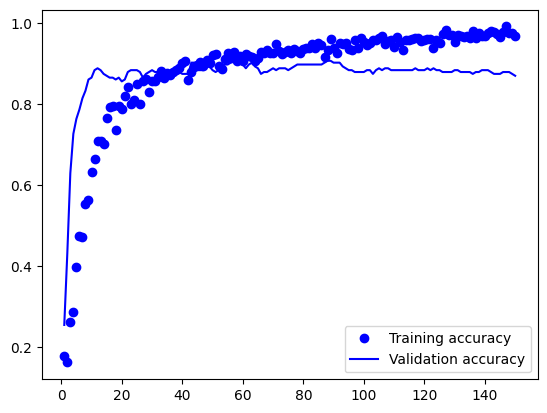

filepath after ['.data-00000-of-00001', 'checkpoint', '.index']
filepath after <tensorflow.python.training.tracking.util.CheckpointLoadStatus object at 0x7f6d9c709f10>
7/7 [==============================] - 0s 6ms/step - loss: 0.4762 - accuracy: 0.9074
Test accuracy: 90.74%
TOTAL TIME:  0.33810877799987793


In [ ]:
trained_model, predictions= run_experiment(X_train1, y_train_arr1, X_test1, y_test_arr1)


In [ ]:
trained_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None)]      0         
                                                                 
 positional_embedding_3 (Pos  (None, None, 150)        4200      
 itionalEmbedding)                                               
                                                                 
 dropout_21 (Dropout)        (None, None, 150)         0         
                                                                 
 encoder_3 (Encoder)         (None, None, 150)         726010    
                                                                 
 dropout_26 (Dropout)        (None, None, 150)         0         
                                                                 
 global_max_pooling1d_3 (Glo  (None, 150)              0         
 balMaxPooling1D)                                          